Annotating and reading the Walsh lab data that was uniformly processed by Taejeon Bae using the bsmn-pipeline.  The number of calls per sample is unexpectedly high in this data set: much higher than reported by Rodin et al (see https://www.biorxiv.org/content/10.1101/2020.02.11.944413v1), who used MosaicForecast instead of the bsmn-pipeline.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import attila_utils
from bsmcalls import readVCF, individuals, preprocessing
import attila_utils
%matplotlib inline

In [2]:
data = individuals.get_datasets(merge=True)
data['tissue'] = data.index.get_level_values('Tissue')
data['individual ID'] = data.index.get_level_values('Individual ID')
def get_dataset(dataset='Chess'):
    dset = data.copy().loc[data['Dataset'] == dataset, :]
    dset['Dx'] = dset['Dx'].cat.remove_unused_categories()
    return(dset)

chess = get_dataset('Chess')
walsh = get_dataset('Walsh')

### Total number of calls

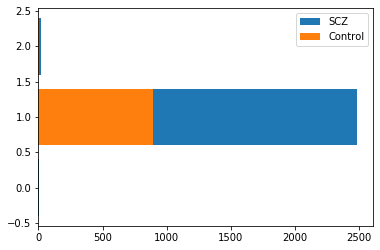

In [42]:
c = chess.groupby(['Tissue', 'Dx']).size()
fig, ax = plt.subplots()
#c.xs('Control', level='Dx').plot(kind='barh', ax=ax, label='Control')
#c.xs('SCZ', level='Dx').plot(kind='barh', ax=ax, label='SCZ')
ax.barh(range(3), c.xs('SCZ', level='Dx'), label='SCZ')
ax.barh(range(3), c.xs('Control', level='Dx'), label='Control')
ax.legend()

In [31]:
w = walsh.groupby(['Tissue', 'Dx']).size()

### Number of samples

### Calls per sample

['named-figure/ncalls-chess-walsh-boxplot.png',
 'named-figure/ncalls-chess-walsh-boxplot.pdf']

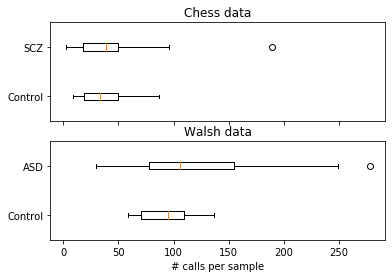

In [8]:
%matplotlib inline
c = chess.groupby(['Tissue', 'Dx'])['individual ID'].value_counts()
ccon = c.xs(('NeuN_pl', 'Control'), level=('Tissue', 'Dx'))
caff = c.xs(('NeuN_pl', 'SCZ'), level=('Tissue', 'Dx'))
w = walsh.groupby(['Tissue', 'Dx'])['individual ID'].value_counts()
wcon = w.xs(('frontal cortex', 'Control'), level=('Tissue', 'Dx'))
waff = w.xs(('frontal cortex', 'ASD'), level=('Tissue', 'Dx'))
# plot figure
fig, ax = plt.subplots(2,1, sharex=True)
lines = ax[0].boxplot([ccon, caff], vert=False, labels=['Control', 'SCZ'])
ax[0].set_title('Chess data')
lines = ax[1].boxplot([wcon, waff], vert=False, labels=['Control', 'ASD'])
ax[1].set_title('Walsh data')
ax[1].set_xlabel('# calls per sample')
attila_utils.savefig(fig, 'ncalls-chess-walsh-boxplot')

['named-figure/ncalls-chess-walsh-hist.png',
 'named-figure/ncalls-chess-walsh-hist.pdf']

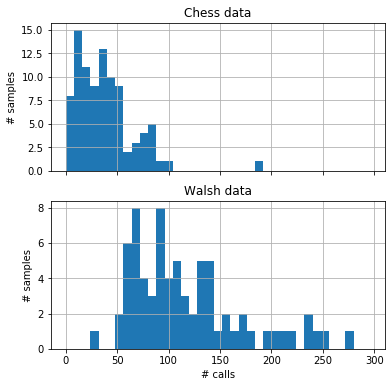

In [6]:
bins = np.arange(0, 304, 8)
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
c.hist(ax=ax[0], bins=bins)
w.hist(ax=ax[1], bins=bins)
ax[0].set_title('Chess data')
ax[1].set_title('Walsh data')
ax[1].set_title('Walsh data')
ax[0].set_ylabel('# samples')
ax[1].set_ylabel('# samples')
ax[1].set_xlabel('# calls')
attila_utils.savefig(fig, 'ncalls-chess-walsh-hist')

In [7]:
%connect_info

{
  "shell_port": 38895,
  "iopub_port": 47645,
  "stdin_port": 51985,
  "control_port": 44417,
  "hb_port": 47917,
  "ip": "127.0.0.1",
  "key": "a034825a-bfc7e688221c3e0af614af83",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-789ad01f-3c84-4a07-b01d-418c612cb87d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
